<a href="https://colab.research.google.com/github/tinayiluo0322/Computer-Engineering-Machine-Learning-and-Deep-Neural-Nets-Projects/blob/main/Construct_Train_Optimize_CNN_Models/simplenn_cifar10_swish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing SimpleNN on CIFAR-10

#### Luopeiwen Yi


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import os

In [ ]:
# Change this to the absolute path where dataset.py and utils.py are stored
CODE_PATH = "/content/drive/MyDrive/CNN_hw"

# Add this path to sys.path so Python can find it
sys.path.append(CODE_PATH)

# Check if Colab can see the files
print("Files in directory:", os.listdir(CODE_PATH))

Files in directory: ['sample_predictions.csv', 'save_test_predictions.ipynb', '__pycache__', 'tools', 'simplenn-cifar10.ipynb']


# Optimization 3: Activation Function

## Step 1: Build the model


In [ ]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)  # Swish function

In [ ]:
# Define SimpleNN with batch normalization
class SimpleNN_BN(nn.Module):
    def __init__(self):
        super(SimpleNN_BN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)  # BN Layer after conv1
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)  # BN Layer after conv2
        self.fc1   = nn.Linear(16 * 6 * 6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))  # Apply BN before activation
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [ ]:
class SimpleNN_BN_Swish(nn.Module):
    def __init__(self):
        super(SimpleNN_BN_Swish, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16 * 6 * 6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        self.swish = Swish()  # Swish activation

    def forward(self, x):
        out = self.swish(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = self.swish(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.swish(self.fc1(out))
        out = self.swish(self.fc2(out))
        out = self.fc3(out)
        return out

### Sanity Check

In [ ]:
# Define the SimpleNN model
model = SimpleNN_BN_Swish()

# Create a dummy input tensor with the same shape as CIFAR-10 images (batch_size=1, channels=3, height=32, width=32)
dummy_input = torch.randn(1, 3, 32, 32)  # Shape: (1, 3, 32, 32)

# Pass the dummy input through the model
output = model(dummy_input)

# Check the output shape
print(f"Output shape: {output.shape}")  # Should be (1, 10) since we have 10 classes

# Count total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Output shape: torch.Size([1, 10])
Total number of parameters: 82078


In [ ]:
from torchsummary import summary

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the SimpleNN model and move it to the selected device
model = SimpleNN_BN_Swish().to(device)

# Create a dummy input tensor and move it to the same device as the model
dummy_input = torch.randn(1, 3, 32, 32).to(device)  # Ensure input is on the same device

# Pass the dummy input through the model
output = model(dummy_input)

# Check the output shape
print(f"Output shape: {output.shape}")  # Should be (1, 10) since we have 10 classes

# Count total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

# Print model summary (Ensure model is on the correct device)
summary(model, (3, 32, 32), device=device.type)  # Specify the device

Using device: cuda
Output shape: torch.Size([1, 10])
Total number of parameters: 82078
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             608
       BatchNorm2d-2            [-1, 8, 28, 28]              16
             Swish-3            [-1, 8, 28, 28]               0
            Conv2d-4           [-1, 16, 12, 12]           1,168
       BatchNorm2d-5           [-1, 16, 12, 12]              32
             Swish-6           [-1, 16, 12, 12]               0
            Linear-7                  [-1, 120]          69,240
             Swish-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
            Swish-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 82,078
Trainable params: 82,078
Non-trainable params: 0
----------

## Step 1: Set up preprocessing functions


In [ ]:
import torchvision.transforms as transforms

# Data augmentation for training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random cropping
    transforms.RandomHorizontalFlip(),  # Random flipping
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))  # Normalize
])

# No data augmentation for validation set
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

ToTensor(): Converts PIL images to PyTorch tensors so they can be used in deep learning models.

Normalize(mean, std): Standardizes pixel values to a mean of (0.4914, 0.4822, 0.4465) and std of (0.2023, 0.1994, 0.2010), helping the model converge faster.


## Step 2: Set up dataset and dataloader


In [ ]:
# Do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# A few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

# Construct dataset
train_set = CIFAR10(
    root=DATA_ROOT,
    mode='train',
    download=True,
    transform=transform_train  # Apply training preprocessing
)

val_set = CIFAR10(
    root=DATA_ROOT,
    mode='val',
    download=True,
    transform=transform_val  # Apply validation preprocessing
)

# Construct dataloaders
train_loader = DataLoader(
    train_set,
    batch_size=TRAIN_BATCH_SIZE,  # Use predefined batch size
    shuffle=True,  # Shuffle training data for randomness
    num_workers=4  # Speed up data loading
)

val_loader = DataLoader(
    val_set,
    batch_size=VAL_BATCH_SIZE,  # Use predefined batch size
    shuffle=False,  # No need to shuffle validation data
    num_workers=4
)

# Sanity Check: Print dataset sizes
print(f"Train dataset size: {len(train_set)} images")
print(f"Validation dataset size: {len(val_set)} images")

# Check a single batch
sample_batch, sample_labels = next(iter(train_loader))
print(f"Sample batch shape: {sample_batch.shape}, Labels shape: {sample_labels.shape}")


141746176it [00:03, 46762805.73it/s]                                


Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Train dataset size: 45000 images
Validation dataset size: 5000 images
Sample batch shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128])


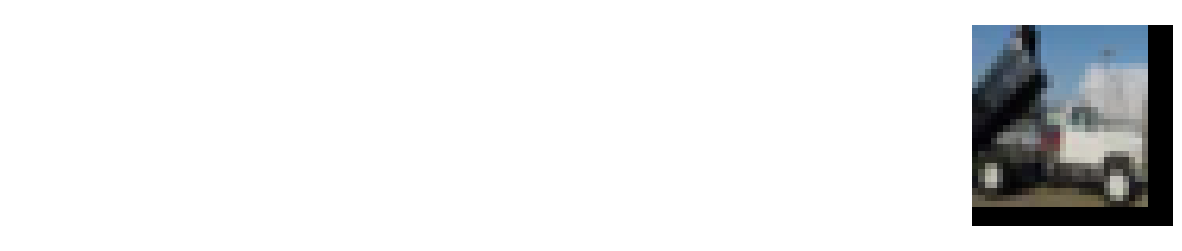

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load one batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Function to unnormalize and display images
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert to HWC format
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = img * std + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)

# Plot some augmented images
fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i in range(5):
    imshow(images[i])
    axes[i].axis('off')
plt.show()

## Step 4: Set up the loss function and optimizer
Loss function/objective function is used to provide "feedback" for the neural networks. Typically, we use multi-class cross-entropy as the loss function for classification models. As for the optimizer, we will use SGD with momentum.

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Hyperparameters (Do NOT change)
INITIAL_LR = 0.1  # Initial learning rate
MOMENTUM = 0.9  # Momentum for optimizer
REG = 1e-4  # L2 regularization (weight decay)

# Create loss function (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

# Add optimizer (SGD with Momentum and L2 Regularization)
optimizer = optim.SGD(
    model.parameters(),  # Optimizing model parameters
    lr=INITIAL_LR,  # Learning rate
    momentum=MOMENTUM,  # Momentum factor
    weight_decay=REG  # L2 regularization
)

# Sanity check: Print optimizer details
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)


## Step 5: Start the training process.



In [ ]:
import torch
import os

def train_model(model, optimizer, filename, epochs=30):
    """ Train the model and save the best checkpoint """

    CHECKPOINT_FOLDER = "./saved_model_dev"
    best_val_acc = 0

    # Ensure model is on the correct device
    model.to(device)

    model.eval()  # Set model to evaluation mode
    initial_loss = 0
    total_examples = 0
    correct_examples = 0

    with torch.no_grad():  # No gradient calculation
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Copy inputs and targets to the device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass: compute the output
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)
            initial_loss += loss.item()

            # Compute accuracy before training
            _, predicted = torch.max(outputs, 1)
            correct_examples += (predicted == targets).sum().item()
            total_examples += targets.size(0)

            # Only calculate on a small subset (e.g., 1 batch)
            if batch_idx == 0:
                break

    # Compute initial average loss and accuracy
    initial_loss /= (batch_idx + 1)
    initial_acc = correct_examples / total_examples
    print(f"Initial loss before training: {initial_loss:.4f}, Initial accuracy: {initial_acc:.4f}")


    print(f"==> Training {filename} model")
    print("=" * 50)

    for i in range(epochs):
        model.train()  # Set model to training mode
        print(f"Epoch {i}:")

        total_examples = 0
        correct_examples = 0
        train_loss = 0

        # Train loop
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Zero gradients & backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_examples += (predicted == targets).sum().item()
            total_examples += targets.size(0)

        avg_loss = train_loss / len(train_loader)
        avg_acc = correct_examples / total_examples
        print(f"Training loss: {avg_loss:.4f}, Training accuracy: {avg_acc:.4f}")

        # Validation loop
        model.eval()
        total_examples = 0
        correct_examples = 0
        val_loss = 0

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_examples += (predicted == targets).sum().item()
                total_examples += targets.size(0)

        avg_loss = val_loss / len(val_loader)
        avg_acc = correct_examples / total_examples
        print(f"Validation loss: {avg_loss:.4f}, Validation accuracy: {avg_acc:.4f}")

        # Save best model
        if avg_acc > best_val_acc:
            best_val_acc = avg_acc
            if not os.path.exists(CHECKPOINT_FOLDER):
                os.makedirs(CHECKPOINT_FOLDER)
            print(f"Saving best model for {filename}...")
            torch.save({'state_dict': model.state_dict()}, os.path.join(CHECKPOINT_FOLDER, filename))

        print('')

    print("=" * 50)
    print(f"==> Training finished for {filename}! Best validation accuracy: {best_val_acc:.4f}")

Model Comparison

In [ ]:
# Train SimpleNN with BN & ReLU
model_bn_relu = SimpleNN_BN().to(device)
optimizer_bn_relu = torch.optim.SGD(model_bn_relu.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
train_model(model_bn_relu, optimizer_bn_relu, "model_bn_relu.pth")

Initial loss before training: 2.3165, Initial accuracy: 0.0938
==> Training model_bn_relu.pth model
Epoch 0:
Training loss: 1.7022, Training accuracy: 0.3704
Validation loss: 1.4235, Validation accuracy: 0.4786
Saving best model for model_bn_relu.pth...

Epoch 1:
Training loss: 1.4617, Training accuracy: 0.4682
Validation loss: 1.3142, Validation accuracy: 0.5208
Saving best model for model_bn_relu.pth...

Epoch 2:
Training loss: 1.3883, Training accuracy: 0.5037
Validation loss: 1.2565, Validation accuracy: 0.5490
Saving best model for model_bn_relu.pth...

Epoch 3:
Training loss: 1.3083, Training accuracy: 0.5355
Validation loss: 1.1890, Validation accuracy: 0.5780
Saving best model for model_bn_relu.pth...

Epoch 4:
Training loss: 1.2577, Training accuracy: 0.5563
Validation loss: 1.1799, Validation accuracy: 0.5762

Epoch 5:
Training loss: 1.2126, Training accuracy: 0.5734
Validation loss: 1.1811, Validation accuracy: 0.5824
Saving best model for model_bn_relu.pth...

Epoch 6:
Trai

In [ ]:
# Train SimpleNN with BN & Swish
model_bn_swish = SimpleNN_BN_Swish().to(device)
optimizer_bn_swish = torch.optim.SGD(model_bn_swish.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
train_model(model_bn_swish, optimizer_bn_swish, "model_bn_swish.pth")

Initial loss before training: 2.3003, Initial accuracy: 0.1016
==> Training model_bn_swish.pth model
Epoch 0:
Training loss: 1.6372, Training accuracy: 0.3922
Validation loss: 1.3801, Validation accuracy: 0.4964
Saving best model for model_bn_swish.pth...

Epoch 1:
Training loss: 1.3254, Training accuracy: 0.5226
Validation loss: 1.2113, Validation accuracy: 0.5664
Saving best model for model_bn_swish.pth...

Epoch 2:
Training loss: 1.2172, Training accuracy: 0.5679
Validation loss: 1.0912, Validation accuracy: 0.6144
Saving best model for model_bn_swish.pth...

Epoch 3:
Training loss: 1.1482, Training accuracy: 0.5909
Validation loss: 1.0630, Validation accuracy: 0.6160
Saving best model for model_bn_swish.pth...

Epoch 4:
Training loss: 1.1028, Training accuracy: 0.6109
Validation loss: 1.0412, Validation accuracy: 0.6376
Saving best model for model_bn_swish.pth...

Epoch 5:
Training loss: 1.0628, Training accuracy: 0.6261
Validation loss: 1.0084, Validation accuracy: 0.6438
Saving b

Swish performs better than Relu as it has increased the validation accuracy from 68% to 72%